# Horizontal divergence

In [1]:
# %run _setup.py
import os
figsdir = os.path.join(os.sep, 'g', 'data', 'v45', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')

import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import xgcm

from gsw import sigma0, SA_from_SP, p_from_z

from oceanpy import define_grid, horizontal_divergence, Contour, haversine
import pyproj

import matplotlib.pyplot as plt
import cmocean as cmo
import string

savefig=True

fs_small = 20
fs_large = 22
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

In [2]:
def coord_cross(along_section, coord_sel):
    idx = np.argmin([haversine([ln, coord_sel[0]], [lt, coord_sel[1]])[0]
                     for ln, lt in zip(along_section.xt_ocean, along_section.yt_ocean)])
    return along_section['along-section'][idx]

In [3]:
database = '/g/data/ik11/databases/cosima_master.db'
session = cc.database.create_session(db=database)

expt = '01deg_jra55v140_iaf'

In [4]:
client = Client(n_workers=8, memory_limit='180GB')
client

<Client: 'tcp://127.0.0.1:36107' processes=8 threads=16, memory=359.38 GiB>

## Load data

In [5]:
# data output frequency
freq = '1 daily'

# time limits of dataset
start, end = '1997-04-01', '1997-04-30'
time_lim = slice(start, end)

In [6]:
# load variables 
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start, end_time=end)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start, end_time=end)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start, end_time=end)
wt = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency=freq, start_time=start, end_time=end)

temp = cc.querying.getvar(expt=expt, variable='temp', session=session, frequency=freq, start_time=start, end_time=end)
salt = cc.querying.getvar(expt=expt, variable='salt', session=session, frequency=freq, start_time=start, end_time=end)

# load coordinates
dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)
dzt = cc.querying.getvar(expt=expt, variable='dzt', session=session, frequency='1 monthly', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

area_t = cc.querying.getvar(expt=expt, variable='area_t', session=session, frequency='static', n=1)
area_u = cc.querying.getvar(expt=expt, variable='area_u', session=session, frequency='static', n=1)

# lont = cc.querying.getvar(expt=expt, variable='geolon_t', session=session, frequency='static', n=1)
# latt = cc.querying.getvar(expt=expt, variable='geolat_t', session=session, frequency='static', n=1)

# lonu = cc.querying.getvar(expt=expt, variable='geolon_c', session=session, frequency='static', n=1)
# latu = cc.querying.getvar(expt=expt, variable='geolat_c', session=session, frequency='static', n=1)

# kmt = cc.querying.getvar(expt=expt, variable='kmt', session=session, frequency='static', n=1)
# kmu = cc.querying.getvar(expt=expt, variable='kmu', session=session, frequency='static', n=1)

geolat_t = cc.querying.getvar(expt,'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt,'geolon_t', session=session, n=1)

# load topography
ht = cc.querying.getvar(expt=expt, variable='ht', session=session, frequency='static', n=1)

## Select regional data

In [7]:
# location limits of dataset
lon_lim = slice(-224.2, -212)
lat_lim = slice(-53.5, -47.5)
flex_period = slice('1997-04-10', '1997-04-25')

# select spatial area
sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
wt_lim = wt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
# wt_ekm_lim = wt_ekm.sel(xt_ocean=lon_lim, yu_ocean=lat_lim)

temp_lim = temp.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
salt_lim = salt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

lat_t = geolat_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dzt_lim = dzt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

areat_lim = area_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
areau_lim = area_u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

ht_lim = ht.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

# lont_lim = lon.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
# latt_lim = lat.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

## Define Grid

In [8]:
# merge variables in dataset
# ds = xr.merge([u_lim, v_lim, dxt_lim, dyt_lim])
# ds = xr.merge([u_lim, v_lim, dxt_lim, dyt_lim, dxu_lim, dyu_lim])

ds = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim, areat_lim, areau_lim, ht_lim])
ds = xr.merge([ds, sl_lim.sel(time=flex_period), 
               u_lim.sel(time=flex_period), v_lim.sel(time=flex_period),
               wt_lim.sel(time=flex_period)])

coords = {'xt_ocean': None, 'yt_ocean': None, 'st_ocean': None, 'xu_ocean': 0.5, 'yu_ocean': 0.5, 'sw_ocean': 0.5}
distances=('dxt', 'dyt', 'dzt', 'dxu', 'dyu')
areas=('area_u', 'area_t')
dims=('X', 'Y', 'S')

grid = define_grid(ds, dims, coords, distances, areas, periodic=False)
grid

<xgcm.Grid>
S Axis (not periodic, boundary='extend'):
  * center   st_ocean --> right
  * right    sw_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center

## Calculate GSW variables

In [9]:
hydro = xr.merge([temp_lim, salt_lim])
hydro = hydro.sel(time=flex_period)

In [10]:
st_ocean = hydro.st_ocean.values
yt_ocean = hydro.yt_ocean.values
xt_ocean = hydro.xt_ocean.values
time = hydro.time.values

lat_t_3d = np.broadcast_to(lat_t, st_ocean.shape + (lat_t.shape))
z_3d = np.broadcast_to(-st_ocean, lat_t_3d.T.shape).T

pressure = xr.DataArray(p_from_z(z_3d, lat_t_3d), 
                        coords = [st_ocean, yt_ocean, xt_ocean], 
                        dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
                        name = 'pressure',
                        attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'})
SA = xr.DataArray(SA_from_SP(hydro.salt, pressure, lon_t, lat_t), 
                  coords = [time, st_ocean, yt_ocean, xt_ocean], 
                  dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'], 
                  name = 'SA', 
                  attrs = {'standard_name': 'sea_water_absolute_salinity', 'units':'g kg-1'})

CT = hydro.temp-273
CT.name = 'CT'
CT.attrs.update(units='degC')

sig0 = sigma0(SA, CT)
sig0.name = 'sigma0'
sig0.attrs.update(standard_name='sea_water_potential_density')
sig0.attrs.update(units='kg m-3')

# density contours
watermass = {
    'ML': (np.nan, 26.75),
    'SAMW': (26.75, 26.95),
    'AAIW': (26.95, 27.25, 27.5),
    'UCDW': (27.5, 27.75),
    'LCDW': (27.75, 28.27),
    'AABW': (28.27, 28.5) # water with a <0 potential temperature
}
density_levels = np.unique(np.concatenate([value for value in watermass.values()]))

# mid_density_levels=(density_levels[:-1] + density_levels[1:])/2

In [11]:
hydro

<xarray.Dataset>
Dimensions:   (xt_ocean: 122, yt_ocean: 95, st_ocean: 75, time: 16)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean  (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    salt      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
Attributes: (12/14)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-06-09
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Source code: https://github.com/COSIMA/access-om2 License...

In [12]:
core_contour = -0.4

ut_contours = np.linspace(-0.1, 0.7, 5)
w_contours = [-1.5e-4, -1e-4, -0.5e-4, 0.5e-4, 1e-4, 1.5e-4]
wt_contours = [-5e-4, -3e-4, -1e-4,  1e-4,  3e-4, 5e-4]
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
slc = slice(None, None, 2)

## Horizontal divergence from total velocities in model

In [13]:
ds

<xarray.Dataset>
Dimensions:    (xt_ocean: 122, yt_ocean: 95, xu_ocean: 122, yu_ocean: 94,
                time: 16, st_ocean: 75, sw_ocean: 75)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * time       (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * sw_ocean   (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    area_u     (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 95, 122), meta=np.ndarray>
    u          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    v          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    wt         (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

In [14]:
divu = horizontal_divergence(ds, grid, delta_names=('dxt', 'dyt'))
divu.name = 'divu'
divu.attrs['long_name'] = r"$\nabla_h \cdot {\bf u}$"

In [15]:
u_grd = grid.interp(grid.interp(ds.u, 'X'), 'Y')
v_grd = grid.interp(grid.interp(ds.v, 'X'), 'Y')
divu_grd = grid.interp(grid.interp(divu, 'X'), 'Y')

w_grd = grid.interp(ds.wt, 'S')
u_grd.name, v_grd.name, w_grd.name = 'u', 'v', 'wt'
ds['u'], ds['v'], ds['divu'], ds['wt'], ds['wt_inv'] = u_grd, v_grd, divu_grd, w_grd, -w_grd

In [16]:
ds = xr.merge([ds, sig0])
ds = ds.sel(time=flex_period).mean('time')
ds = ds.drop_vars(['dxt', 'dyt', 'dxu', 'dyu', 'area_t', 'area_u', 'xu_ocean', 'yu_ocean', 'sw_ocean'])
ds = ds.sel(xt_ocean=slice(-224, -212))
ds = ds.assign_coords(xt_ocean=((ds.xt_ocean + 180) % 360) - 180)

In [17]:
# make along and cross contour sections
cont = Contour(ds, coords=('xt_ocean', 'yt_ocean'))
cont.get_coords(contour_name='sea_level', contour_value=core_contour, interp=True, spacing=20000)

# along contour section
along_section = cont.along_section(var_name=('u', 'v'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section', decompose=True)

# across contour sections
UTM54 = pyproj.Proj('EPSG:32754')
npnts = 10
spacing = 20000 # m

coord_trough =(-222.6, -50.4)
cross_section_trough = cont.cross_section(
    coord_sel=coord_trough, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_trough2 =(-222.25, -50)
cross_section_trough2 = cont.cross_section(
    coord_sel=coord_trough2, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_trough3 =(-221.2, -50)
cross_section_trough3 = cont.cross_section(
    coord_sel=coord_trough3, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_between =(-219.7, -50.25)
cross_section_between = cont.cross_section(
    coord_sel=coord_between, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_between2 =(-219, -51)
cross_section_between2 = cont.cross_section(
    coord_sel=coord_between2, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_between3 =(-219, -51.5)
cross_section_between3 = cont.cross_section(
    coord_sel=coord_between3, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_crest =(-217.6, -51.8)
cross_section_crest = cont.cross_section(
    coord_sel=coord_crest, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_crest2 =(-215.8, -51.5)
cross_section_crest2 = cont.cross_section(
    coord_sel=coord_crest2, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

coord_crest3 =(-214.5, -51)
cross_section_crest3 = cont.cross_section(
    coord_sel=coord_crest3, transform=UTM54, npnts=npnts, spacing=spacing,
    coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)

cross_coords = {
    'cross_section_trough' : [coord_cross(along_section, coord_trough), 'tab:blue', ':'], 
    'cross_section_trough2' : [coord_cross(along_section, coord_trough2), 'tab:blue', '-'], 
    'cross_section_trough3' : [coord_cross(along_section, coord_trough3), 'tab:blue', '--'], 
    'cross_section_between' : [coord_cross(along_section, coord_between), 'tab:orange', ':'],
    'cross_section_between2' : [coord_cross(along_section, coord_between2), 'tab:orange', '-'],
    'cross_section_between3' : [coord_cross(along_section, coord_between3), 'tab:orange', '--'],
    'cross_section_crest' : [coord_cross(along_section, coord_crest), 'tab:green', ':'],
    'cross_section_crest2' : [coord_cross(along_section, coord_crest2), 'tab:green', '-'],
    'cross_section_crest3' : [coord_cross(along_section, coord_crest3), 'tab:green', '--']
}

cross_sections = {
    'cross_section_trough': cross_section_trough, 
    'cross_section_trough2': cross_section_trough2, 
    'cross_section_trough3': cross_section_trough3, 
    'cross_section_between': cross_section_between, 
    'cross_section_between2': cross_section_between2, 
    'cross_section_between3': cross_section_between3, 
    'cross_section_crest': cross_section_crest,
    'cross_section_crest2': cross_section_crest2,
    'cross_section_crest3': cross_section_crest3
}

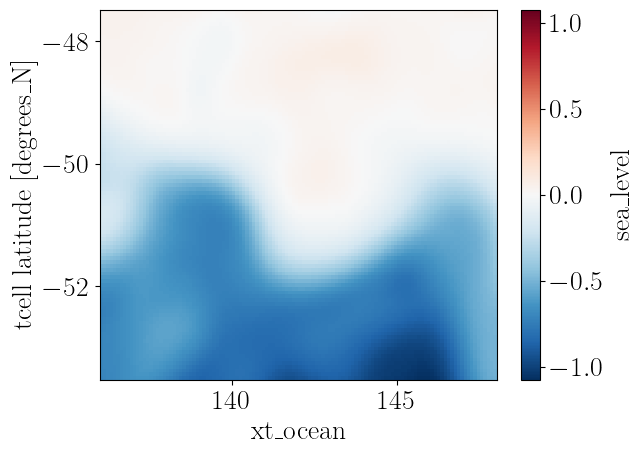

In [30]:
ds.sea_level.plot()

In [31]:
plt.rcParams.update(plt.rcParamsDefault)

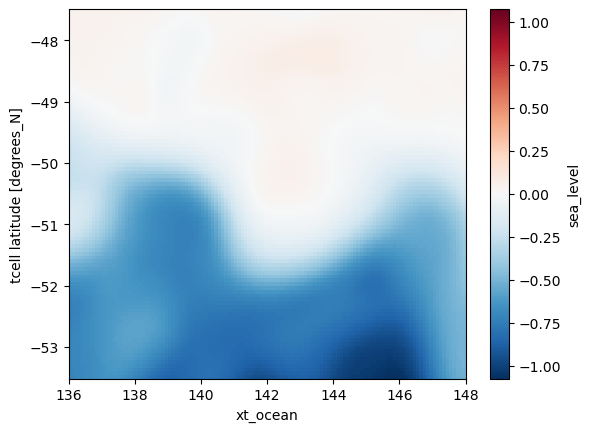

In [32]:
ds.sea_level.plot()

In [24]:
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})

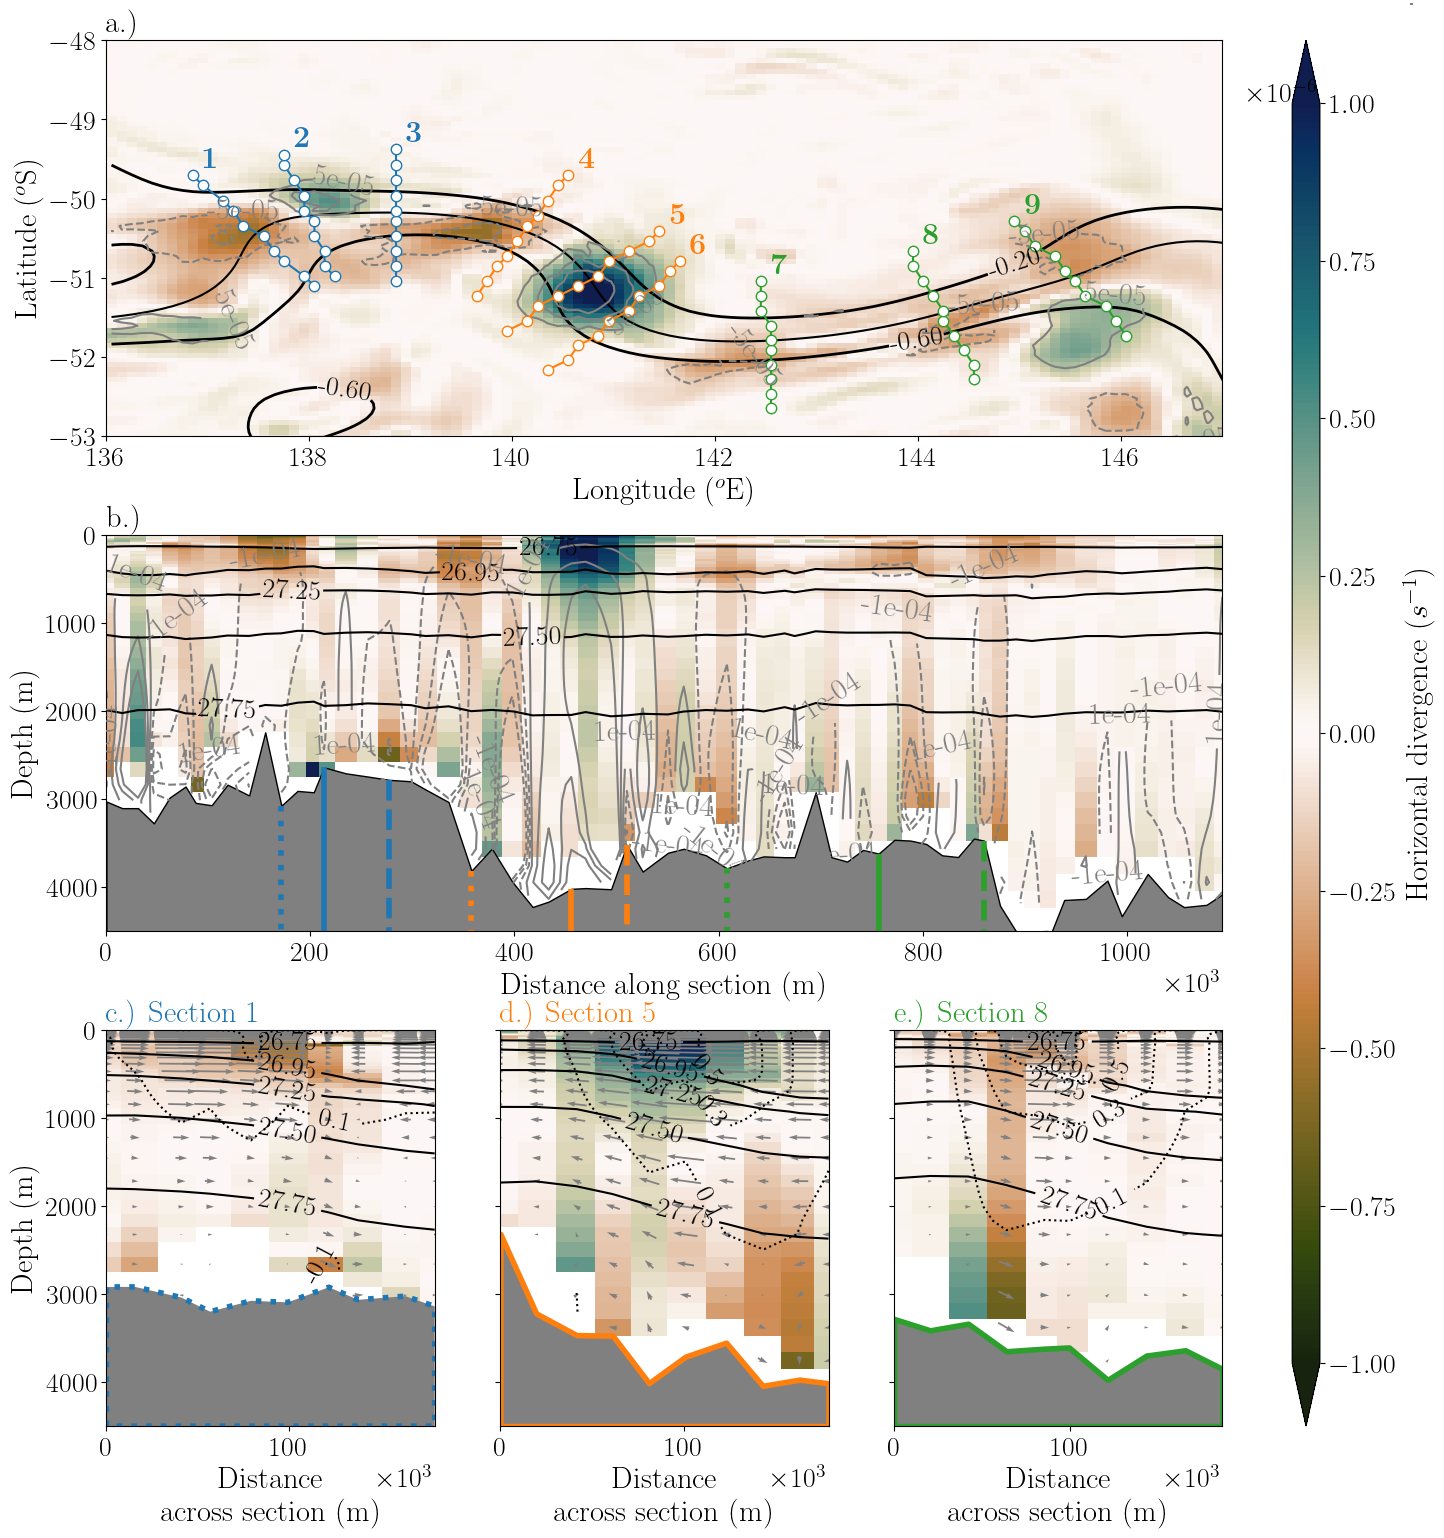

In [25]:
fig = plt.figure(figsize=(18,18), constrained_layout=True)
gs = plt.GridSpec(3, 3, hspace=0.25)
plt.subplot(gs[0, :]), plt.subplot(gs[1, :]), plt.subplot(gs[2, 0:1]), plt.subplot(gs[2, 1:2]), plt.subplot(gs[2, 2:])
ax = fig.get_axes()

cmap = cmo.cm.tarn
vmin, vmax = -1e-6, 1e-6

### 0) Plane view
pcol = ds.divu.isel(st_ocean=30).plot(ax=ax[0], cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
ct_sl = ds.sea_level.plot.contour(ax=ax[0], colors='k', levels=sl_contours, linestyles='solid')
for ib, b in enumerate(sl_contours):
    if b in sl_contours[0::2]:
        zc = ct_sl.collections[ib]
        plt.setp(zc, linewidth=2)
ax[0].clabel(ct_sl, sl_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')

ct_wt = ds.wt.isel(st_ocean=30).plot.contour(ax=ax[0], colors='gray', levels=w_contours)
# plt.setp(ct_wt.collections[1], linewidth=2)
ax[0].clabel(ct_wt, [-.5e-4, .5e-4], inline=True, fmt='%.0e', fontsize=fs_large)

for its, (name, data) in enumerate(cross_sections.items()):
    ax[0].plot(data.xt_ocean, data.yt_ocean, '.-', color=cross_coords[name][1], markersize=15, markerfacecolor='w')
    ax[0].text(data.xt_ocean[-1]+.1, data.yt_ocean[-1]+.1, r'${\bf %s}$' %(its+1), color=cross_coords[name][1], size=fs_large)

ax[0].set_ylim([-53, -48])
ax[0].set_xlim([136, 147])
ax[0].set_title('')
ax[0].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
ax[0].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
ax[0].text(0, 1.02, string.ascii_lowercase[0] + '.)',
           transform=ax[0].transAxes, size=fs_large, weight='bold')

### 1) Along Section
along_section.divu.plot(ax=ax[1], x='along-section', 
                        cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# vertical velocity contours
ct_wt = along_section.wt.plot.contour(
    ax=ax[1], x='along-section', colors='gray', levels=wt_contours)
# ax[1].clabel(ct_wt, wt_contours[1::3], inline=True, fmt='%.0e', fontsize=fs_large)


# density contours
cont = along_section.sigma0.plot.contour(ax=ax[1], x='along-section', levels=density_levels, colors='k')
ax[1].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, fontsize=fs_small)

# depth contour
ax[1].fill_between(
    along_section['along-section'], along_section.ht, 5000, fc='gray', ec='k')

ax[1].set_xlim([along_section['along-section'].min(), along_section['along-section'].max()])

# position cross-sections vertical lines
for (coord, color, style) in cross_coords.values():
    ax[1].vlines(coord, ymin=ds.ht.sel(xt_ocean=coord.xt_ocean, yt_ocean=coord.yt_ocean, method='nearest').values, 
                    ymax=5000, color=color, lw=4, linestyle=style)

ax[1].set_xlabel(r'Distance along section (m)', fontsize=fs_large)

### 2) Cross Sections
manual_locations = {
    0: [(75e3, 2500), (125e3, 1000)],
    1: [(110e3, 2000), (110e3, 1000), (110e3, 500)],
    2: [(125e3, 2000), (125e3, 1000), (125e3, 500)],
}
sections = ['cross_section_trough', 'cross_section_between2', 'cross_section_crest2']
ct = []
iax = 1
for isec, section in enumerate(cross_sections.keys()):
    if section in sections:
        iax += 1
        # css[isec] = cross_sections[section]
        data = cross_sections[section]
        data.divu.plot(ax=ax[iax], x='cross-section', 
                                       cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
        
        # cross front velocity vectors
        scale = 1e-5
        quiv = data.sel(st_ocean=slc).plot.quiver(ax=ax[iax], color='gray',
            x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', width=3e-4*fig.get_size_inches()[0], scale=scale)
        
        # density contours
        cont = data.sigma0.plot.contour(ax=ax[iax], x='cross-section', levels=density_levels, colors='k')
        ax[iax].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, fontsize=fs_small, use_clabeltext=True)
        
        # along front velocity
        ct.append(data.ut.plot.contour(ax=ax[iax], x='cross-section', colors='k', levels=ut_contours, linestyles='dotted'))

        # topography
        ax[iax].fill_between(data['cross-section'], data.ht, 4500,
                              fc='gray', ec=cross_coords[section][1], lw=4, linestyle=cross_coords[section][2])

        ax[iax].set_xlim([data['cross-section'].min(), data['cross-section'].max()])

        # labelling
        ax[iax].text(0, 1.02, string.ascii_lowercase[iax] + '.) Section %s' %(isec+1),
                     transform=ax[iax].transAxes, size=fs_large, weight='bold', color=cross_coords[section][1])
        
for iax in range(1, len(ax)):
    
#     r, c = iax // ncols, iax % ncols
    ax[iax].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[iax].set_ylabel(r'Depth (m)', fontsize=fs_large)
    if iax > 1:
        ax[iax].set_xlabel('Distance \n across section (m)', fontsize=fs_large)
    if iax > 2:
        ax[iax].set_ylabel('')
        ax[iax].set_yticklabels('')
   
    ax[iax].set_ylim([0,4500])
    ax[iax].invert_yaxis()
    
    # labelling
    if iax < 2:
        ax[iax].text(0, 1.02, string.ascii_lowercase[iax] + '.)',
                     transform=ax[iax].transAxes, size=fs_large, weight='bold')
    
cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('Horizontal divergence ($s^{-1}$)', fontsize=fs_large)

ax[1].clabel(ct_wt, wt_contours[2:-2], inline=True, fmt='%.0e', fontsize=fs_large)
for isec, section in enumerate(sections):
    ax[iax].clabel(ct[isec], inline=1, fmt='%.1f', inline_spacing=10, fontsize=fs_small, use_clabeltext=True, manual=manual_locations[isec])

qk = plt.quiverkey(quiv, 0.8, 1.0, scale, r'$%.0e~\mathrm{ms}^{-1}$' %scale, labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})


In [26]:
savefig

True

In [27]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '07_hor-divergence' + extension), 
                    transparent=transparent, bbox_inches='tight')

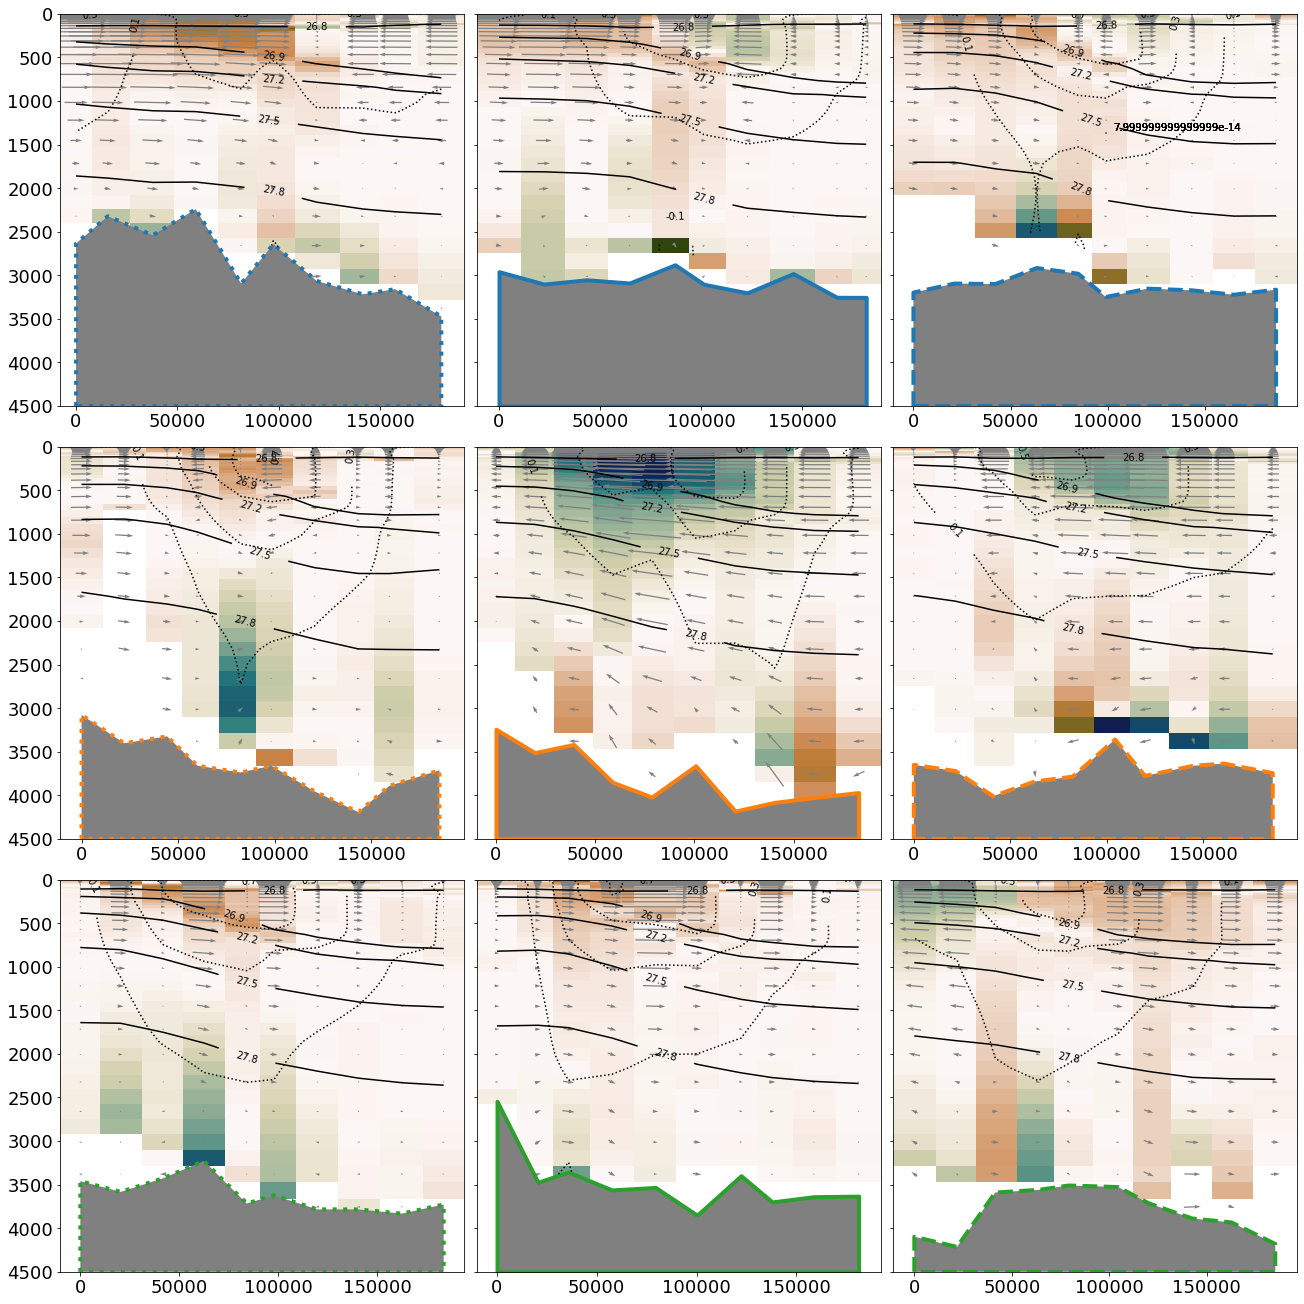

In [18]:
var = 'divu'
vmin, vmax = -1e-6, 1e-6
cmap=cmo.cm.tarn

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), constrained_layout=True, sharey=True)

for iax, (name, data) in enumerate(cross_sections.items()):

    r, c = iax // ncols, iax % ncols

    # vertical along and cross sectional velocities
    pcol = cross_sections[name][var].plot(ax=ax[r, c], x='cross-section', cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    ct = cross_sections[name].ut.plot.contour(ax=ax[r, c], x='cross-section', colors='k', levels=ut_contours, linestyles='dotted')
    ax[r, c].clabel(ct, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

    cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax[r, c], color='gray',
        x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', scale=1e-5)

    # density contours
    cont = cross_sections[name].sigma0.plot.contour(ax=ax[r, c], x='cross-section', levels=density_levels, colors='k')
    ax[r, c].clabel(cont, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

    # topography
    ax[r, c].fill_between(cross_sections[name]['cross-section'], cross_sections[name].ht, 4500,
                          fc='gray', ec=cross_coords[name][1], 
                          lw=4, linestyle=cross_coords[name][2])
    
    ax[r, c].set_ylim([0,4500])
    ax[r, c].invert_yaxis()
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')

In [10]:
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds)#, periodic=['X']

In [11]:
grid

<xgcm.Grid>
Y Axis (periodic, boundary=None):
  * center   yt_ocean --> outer
  * outer    yu_ocean --> center
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [12]:
# method as relative vorticity
dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
dvdy = grid.interp(grid.diff(ds.v, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X')

div_h_gcm = dudx + dvdy

# interpolated on t-cells
dudx_t = grid.interp(grid.diff(ds.u, 'X', boundary='extend'), 'Y', boundary='extend') / ds.dxt
dvdy_t = grid.interp(grid.diff(ds.v, 'Y', boundary='extend'), 'X', boundary='extend') / ds.dyt

div_ht_gcm = dudx_t + dvdy_t

# interpolated on u-cells
div_hu_gcm = grid.interp(grid.interp(div_ht_gcm, 'X', boundary='extend'), 'Y', boundary='extend')

In [13]:
# # method 1 Navid 
# dvdx = grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
# dudy = grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X')

# zeta = dvdx - dudy

# # method 2 Navid
# dvdx_t = grid.interp(grid.diff(ds.v, 'X'), 'Y', boundary='extend') / ds.dxt
# dudy_t = grid.interp(grid.diff(ds.u, 'Y', boundary='extend'), 'X') / ds.dyt

# zeta_t = dvdx_t - dudy_t

# # method 3: add interp from t-cells to u-cells for method 2 Navid
# zeta_u = grid.interp(grid.interp(zeta_t, 'X'), 'Y', boundary='extend')

In [14]:
# Alternatives

# on t-points
# dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxu, 'X', boundary='extend'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyt, 'X', boundary='extend'), 'X', boundary='extend')

# dudx = grid.interp(grid.diff(ds.u, 'X', boundary='extend') / grid.interp(ds.dxu, 'X'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyt, 'X'), 'X', boundary='extend')

# dudx = grid.interp(grid.diff(ds.u, 'X', boundary='extend') / grid.interp(ds.dxt, 'Y'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyu, 'Y'), 'X', boundary='extend')

# dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxt, 'Y'), 'Y', boundary='extend')
# dvdy = grid.interp(grid.diff(ds.v, 'Y', boundary='extend') / grid.interp(ds.dyu, 'Y'), 'X')

# dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxt, 'Y'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyt, 'X'), 'X')

# dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxu, 'X'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyt, 'X'), 'X')

# dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxt, 'Y'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyu, 'Y'), 'X')

# dudx = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxu, 'X'), 'Y')
# dvdy = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyu, 'Y'), 'X')

# div_h_gcm = dudx + dvdy

# on u-points
dudx_u = grid.interp(grid.diff(ds.u, 'X') / grid.interp(ds.dxu, 'X'), 'X')
dvdy_u = grid.interp(grid.diff(ds.v, 'Y') / grid.interp(ds.dyu, 'Y'), 'Y')

# div_hu_gcm = dudx_u + dvdy_u


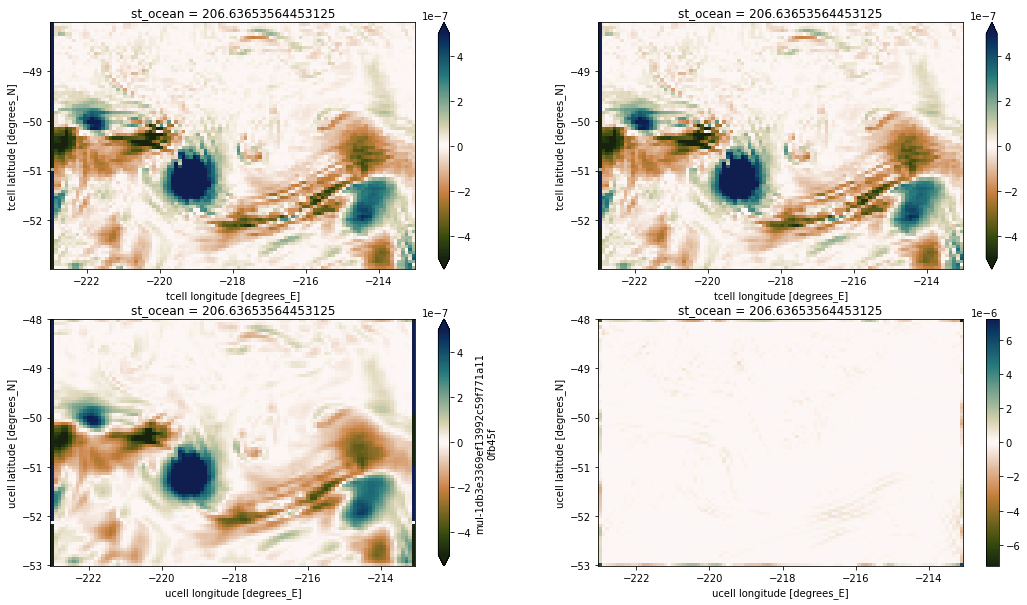

In [15]:
flex_period = slice('1997-04-10', '1997-04-25')
# flex_period = slice('1997-04-09', '1997-04-20')
depth = 200

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))

div_h_gcm.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
    ax=ax[0, 0], cmap=cmo.cm.tarn, vmin=-5e-7, vmax=5e-7)

div_ht_gcm.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
    ax=ax[0, 1], cmap=cmo.cm.tarn, vmin=-5e-7, vmax=5e-7)

div_hu_gcm.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
    ax=ax[1, 0], cmap=cmo.cm.tarn, vmin=-5e-7, vmax=5e-7)

(div_hu_gcm - (dudx_u + dvdy_u)).sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
    ax=ax[1, 1], cmap=cmo.cm.tarn)


In [16]:
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,10))

# # method Navid
# zeta.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
#     ax=ax[0, 0],cmap=cmo.cm.curl, vmin=-1.5e-5, vmax=1.5e-5)

# # method t-cells
# zeta_t.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
#     ax=ax[0, 1],cmap=cmo.cm.curl, vmin=-1.5e-5, vmax=1.5e-5)

# # method u-cells
# zeta_u.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
#     ax=ax[1, 0],cmap=cmo.cm.curl, vmin=-1.5e-5, vmax=1.5e-5)

# # anomaly methods
# (zeta-zeta_t).sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
#     ax=ax[1, 1],cmap=cmo.cm.curl)

## Take horizontal divergence at u-points (method 3)

In [17]:
div_hu_gcm.name = 'gradu'
div_hu_gcm.attrs['long_name'] = 'Horizontal divergence'

In [18]:
wt_limits = -2.e-3, 2.e-3
gradu_limits = -5e-7, 5e-7
vn_contours = np.linspace(-.5, .5, 11)
wt_contours = np.linspace(-.5e-3, .5e-3, 6)
sl_contours = [-0.45, -0.3, -0.15]

# flex_period = slice('1997-04-10', '1997-04-25')
depth = 200
trough, crest = -221, -218

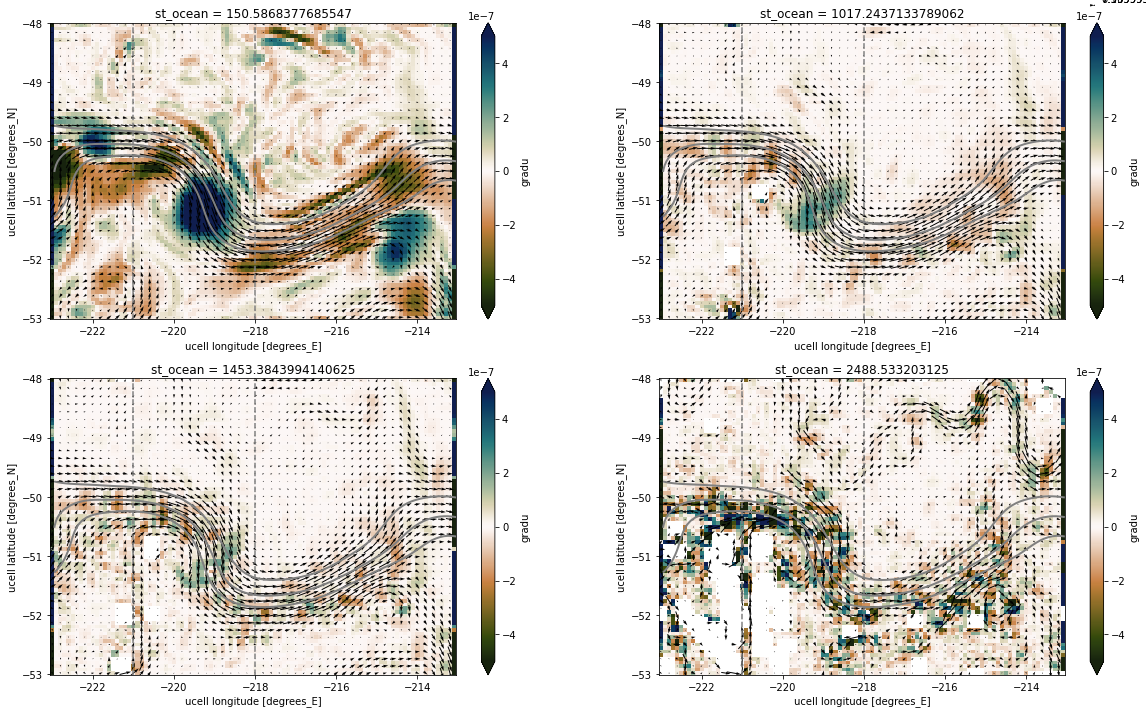

In [19]:
nrows, ncols = 2, 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,12))

for iax, depth in enumerate([150, 1000, 1500, 2500]):
    
    r, c = iax // ncols, iax % ncols
    
    # horizontal divergence vorticity
    div_hu_gcm.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').plot(
        ax=ax[r, c], cmap=cmo.cm.tarn, vmin=gradu_limits[0], vmax=gradu_limits[1])
        
    # sea level
    cont = sl_lim.sel(time=flex_period).mean('time').plot.contour(
            ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=2, colors='gray')

    # velocity vectors
    ds.sel(time=flex_period).mean('time').sel(st_ocean=depth, method='nearest').sel(xu_ocean=slice(None,None,2), yu_ocean=slice(None,None,2)).plot.quiver(
        ax=ax[r, c], x='xu_ocean', y='yu_ocean', u='u', v='v', color='k')

    # crest and trough indictions
    ax[r, c].axvline(trough, linestyle='dashed', color='gray')
    ax[r, c].axvline(crest, linestyle='dashed', color='gray')

In [2]:
from skimage.measure import find_contours
import numpy as np
from oceanpy.tools import haversine

# class Contour():

# def contour_length():

def along_contour_section(contour_var, contour_value, xyz_coords=('longitude', 'latitude', 'depth'), 
                          section_var=None, section_coords=None, 
                          uv=None, interp=False, dist_btwn_cont_pnts=10000):

    """
    Make a section along a contour.

    Parameters
    ----------
    ds -- xarray dataset
    contour_value -- the value for the streamline or contour to follow 
    variable -- variable in dataset to get along contour section
    timemean -- take time mean of the dataset (default True)
    
    Returns
    -------
    
    Examples
    --------
    
    
    
    """
  
    if section_var is None:
        if not all([coord in xyz_coords for coord in contour_var.dims]):
            raise ValueError('Contour field dimensions %s do not correspond with xyz_voords %s', 
                             (contour_var.dims, xyz_coords))            
    else:
        if section_var.ndim > 3:
            raise ValueError('Section field should have no more than 3 dimensions but got %s', 
                             section_var.dims)

    # find longest contour
    contours = find_contours(contour_var.values, contour_value)
    contour = max(contours, key=lambda x: len(x))
    
    # contour indexes
    idx_x, idx_y = contour[:, 1], contour[:, 0]
    ix_floor, iy_floor = np.floor(idx_x).astype(int), np.floor(idx_y).astype(int)
    ix_ceil, iy_ceil = np.ceil(idx_x).astype(int), np.ceil(idx_y).astype(int)    
    
    # contour coordinates and distance
    x_cont = contour_var.isel({xyz_coords[0]: ix_floor})[xyz_coords[0]] + \
    (idx_x - ix_floor) * (contour_var.isel({xyz_coords[0]: ix_ceil})[xyz_coords[0]].values - \
                          contour_var.isel({xyz_coords[0]: ix_floor})[xyz_coords[0]].values)
    y_cont = contour_var.isel({xyz_coords[1]: iy_floor})[xyz_coords[1]] + \
    (idx_y - iy_floor) * (contour_var.isel({xyz_coords[1]: iy_ceil})[xyz_coords[1]].values - \
                          contour_var.isel({xyz_coords[1]: iy_floor})[xyz_coords[1]].values)

    # interp contour with specific distance between contour points
    def contour_interp(cont_coords, dist_btwn_cont_pnts):
        
        cumdist = np.cumsum(haversine(cont_coords[:, 0], cont_coords[:,1])[0])
        cont_dist = np.hstack([[0], cumdist])
        cont_dist_interp = np.linspace(cont_dist[0], cont_dist[-1], 
                                       int(cont_dist[-1] / dist_btwn_cont_pnts) + 1)

        x_cont = np.interp(cont_dist_interp, cont_dist, cont_coords[:, 0])
        y_cont = np.interp(cont_dist_interp, cont_dist, cont_coords[:, 1])
        
        cont_coords=list(zip(x_cont, y_cont))
        
        return cont_coords
    
    # remove duplicate coordinates
    cont_coords = np.array(list(zip(x_cont[xyz_coords[0]].values, y_cont[xyz_coords[1]].values)))
    if interp:
        cont_coords = contour_interp(cont_coords, dist_btwn_cont_pnts)
    cont_coords = np.unique(cont_coords, axis=0)
        
    # select variable at contour points along contour section
    var = contour_var if section_var is None else section_var
    coords = xyz_coords if section_var is None else section_coords
    var_cont_pnt = []
    for x, y in cont_coords:
        var_cont_pnt.append(var.sel({coords[0]: x, coords[1]: y}, 
                                             method='nearest', tolerance=0.1))
    var_cont = xr.concat(var_cont_pnt, dim='contour')

    # make contour coordinate along selected contour points
    distance = haversine(var_cont[coords[0]].values, var_cont[coords[1]].values)[0]
    cumdist = np.cumsum(distance)    
    cont_coord = np.hstack([[0], cumdist])
    var_cont = var_cont.assign_coords({'contour': cont_coord})

    
    # calculate along and cross contour velocities
    # def decompose_vector():
    if uv is not None:
        
        x_cont = uv.isel({'xu_ocean': ix_floor})['xu_ocean'] + \
        (idx_x - ix_floor) * (uv.isel({'xu_ocean': ix_ceil})['xu_ocean'].values - \
                          uv.isel({'xu_ocean': ix_floor})['xu_ocean'].values)
        y_cont = uv.isel({'yu_ocean': iy_floor})['yu_ocean'] + \
        (idx_y - iy_floor) * (uv.isel({'yu_ocean': iy_ceil})['yu_ocean'].values - \
                          uv.isel({'yu_ocean': iy_floor})['yu_ocean'].values)

        # remove duplicate coordinates
        cont_coords = np.array(list(zip(x_cont['xu_ocean'].values, y_cont['yu_ocean'].values)))                                       
        if interp:
            cont_coords = contour_interp(cont_coords, dist_btwn_cont_pnts)
        cont_coords = np.unique(cont_coords, axis=0)
        
        # select variable at contour points along contour section
        uv_cont_pnt = []
        for x, y in cont_coords:
            uv_cont_pnt.append(uv.sel({'xu_ocean': x, 'yu_ocean': y},
                                      method='nearest', tolerance=0.1))
        uv_cont = xr.concat(uv_cont_pnt, dim='contour')

        # make contour coordinate along selected contour points
        distance, bearing = haversine(cont_coords[:, 0], cont_coords[:,1])
        cumdist = np.cumsum(distance)
        cont_coord = np.hstack([[0], cumdist])
        uv_cont = uv_cont.assign_coords({'contour': cont_coord})

        # decompose u,v-velocities along contour
        def bearing2standard(bearing):
            return np.deg2rad((90 - bearing) % 360)
        
        theta = bearing2standard(bearing)
        print(theta)
        try:
            theta[np.where((theta > np.pi/2) & (theta <= np.pi))[0][0]] += np.pi/2
        except IndexError:
            pass
        try:
            theta[np.where((theta > np.pi) & (theta <= (3*np.pi/2)))[0][0]] -= np.pi
        except IndexError:
            pass
        print(theta)
        theta = np.broadcast_to(theta, uv_cont.u[:-1].T.shape).T

        uv_cont['ut'] = uv_cont['u'][:-1] * np.cos(theta) + uv_cont['v'][:-1] * np.sin(theta)
        uv_cont['vn'] = -uv_cont['u'][:-1] * np.sin(theta) + uv_cont['v'][:-1] * np.cos(theta)
    
    return var_cont if uv is None else (var_cont, uv_cont)

In [20]:
sea_level_ct = -0.35
dist = 15000
interp = True

sl_cont, uv_cont = along_contour_section(sl_lim.sel(time=u_lim.time).mean('time'), sea_level_ct, xyz_coords=('xt_ocean', 'yt_ocean'), 
                                         uv=xr.merge([u_lim, v_lim]).mean('time'), interp=interp, dist_btwn_cont_pnts=dist)
div_cont = along_contour_section(sl_lim.sel(time=u_lim.time).mean('time'), sea_level_ct, xyz_coords=('xt_ocean', 'yt_ocean'),
                                 section_var=div_hu_gcm.mean('time'), section_coords=('xu_ocean', 'yu_ocean', 'st_ocean'), 
                                 interp=interp, dist_btwn_cont_pnts=dist)
wt_cont = along_contour_section(sl_lim.sel(time=u_lim.time).mean('time'), sea_level_ct, xyz_coords=('xt_ocean', 'yt_ocean'),
                                section_var=wt_lim.mean('time'), section_coords=('xt_ocean', 'yt_ocean', 'sw_ocean'), 
                                interp=interp, dist_btwn_cont_pnts=dist)

[0.7195587  0.14641605 0.47252154 0.33001219 0.26315984 6.28175506
 6.28175506 6.28175506 6.28175506 6.28175506 5.75501893 5.84194318
 5.86259852 5.86211921 5.49671879 5.86099997 5.35019437 5.29471345
 5.49678161 5.41339772 5.23062701 5.49679663 5.49670035 5.81042483
 5.76816119 5.76880405 5.76944779 6.14623141 5.92085525 6.15425792
 5.91298884 6.28167921 6.28167921 6.28167921 6.28167921 0.69518183
 6.28168256 0.69607832 0.47011242 0.13257506 0.80679507 0.59408486
 0.70101202 0.70235882 0.70370509 0.71892437 0.8629159  0.86155892
 0.86020339 0.85884931 0.85749668 0.85614551 0.72615068 0.15189462
 0.85276647 0.34374934 0.71864277 6.2817453  0.71796749 6.28250799
 5.81010596 6.23455863]
[0.7195587  0.14641605 0.47252154 0.33001219 0.26315984 6.28175506
 6.28175506 6.28175506 6.28175506 6.28175506 5.75501893 5.84194318
 5.86259852 5.86211921 5.49671879 5.86099997 5.35019437 5.29471345
 5.49678161 5.41339772 5.23062701 5.49679663 5.49670035 5.81042483
 5.76816119 5.76880405 5.76944779 6.14

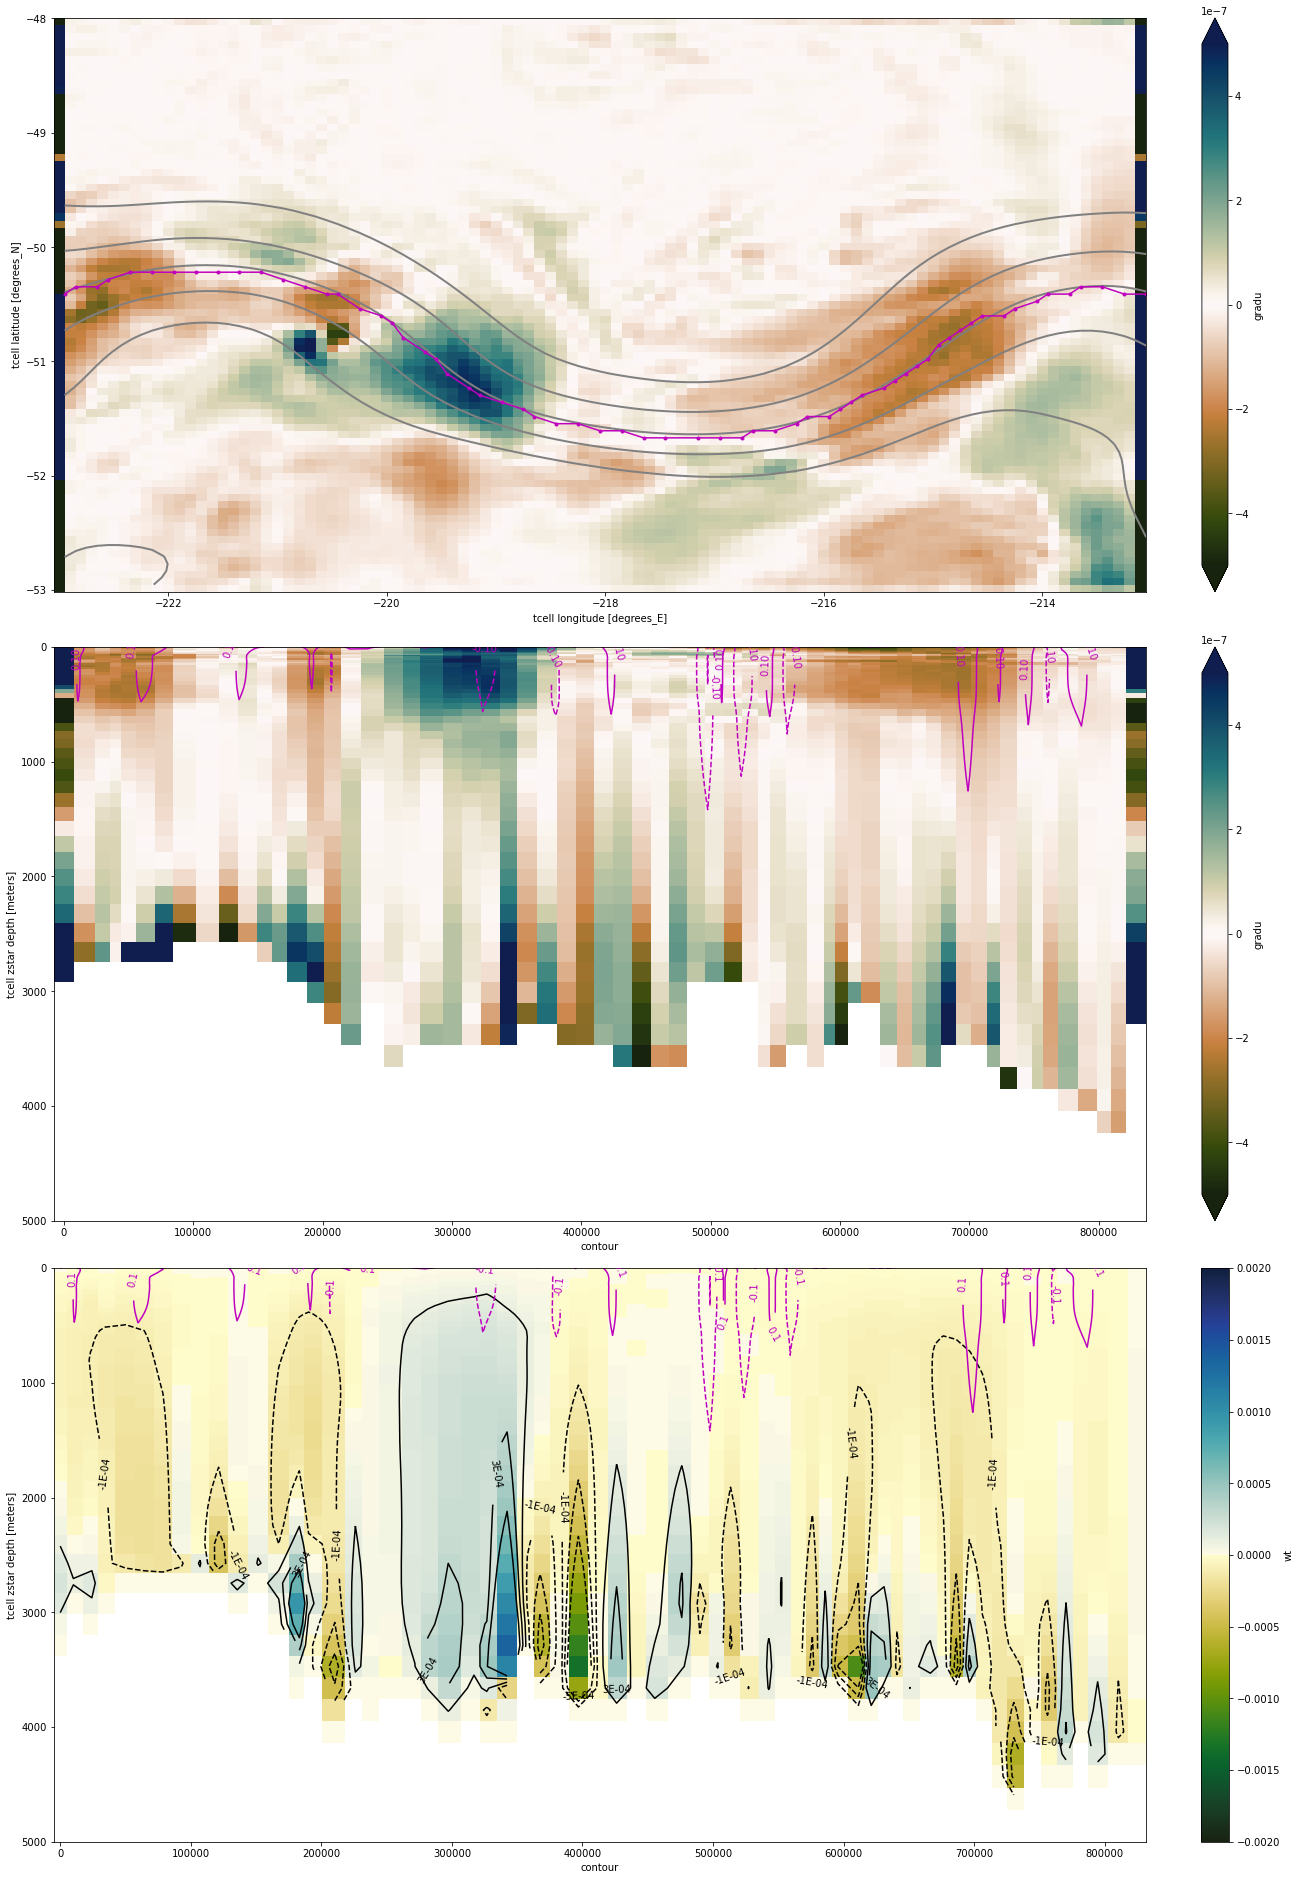

In [21]:
fig, ax = plt.subplots(nrows=3, figsize=(18,26), constrained_layout=True)
# fig.tight_layout()

# horizontal divergence surface
div_hu_gcm.mean('time').sel(st_ocean=200, method='nearest').plot(ax=ax[0],
    cmap=cmo.cm.tarn, vmin=-5e-7, vmax=5e-7)
sl_lim.sel(time=u_lim.time).mean('time').plot.contour(ax=ax[0],
    levels=np.linspace(-0.6, -0.1, 5), linestyles='solid', linewidths=2, colors='gray')

ax[0].plot(sl_cont.xt_ocean, sl_cont.yt_ocean, '.-', color='m')

# horizontal divergence along contour
div_cont.plot(ax=ax[1], x='contour', cmap=cmo.cm.tarn, vmin=gradu_limits[0], vmax=gradu_limits[1])

# cross-contour horizontal velocity
cont = uv_cont.vn.plot.contour(ax=ax[1], x='contour', colors='m', levels=vn_contours[::2])
ax[1].clabel(cont, vn_contours[::2], inline=1, fmt='%.2f')

# vertical velocity
wt_cont.plot(ax=ax[2], x='contour', cmap=cmo.cm.delta_r, vmin=wt_limits[0], vmax=wt_limits[1])
cont = wt_cont.plot.contour(ax=ax[2], x='contour', levels=wt_contours, colors='k')
ax[2].clabel(cont, wt_contours[::2], inline=1, fmt='%.0E')
cont = uv_cont.vn.plot.contour(ax=ax[2], x='contour', colors='m', levels=vn_contours[::2])
ax[2].clabel(cont, vn_contours[::2], inline=1, fmt='%.1f')

for i in range(1,len(ax)):
    ax[i].set_ylim([0,5000])
    ax[i].invert_yaxis()

In [22]:
print('%s-day mean field (%s)' %(len(div_hu_gcm.time), len(sl_lim.sel(time=u_lim.time))))

61-day mean field (61)


## flex_period

In [23]:
# hordiv = xr.merge([
#     sl_lim.sel(time=flex_period).mean('time'),
#     wt_lim.sel(time=flex_period).mean('time'),
#     div_h_gcm.sel(time=flex_period).mean('time'),
#     ht_lim])

In [24]:
# div_cont = contour_section(hordiv, -0.3, 'gradu', timemean=False, xy_coords=('xu_ocean', 'yu_ocean'))[-1]
# wt_cont = contour_section(hordiv, -0.3, 'wt', timemean=False)[-1]
# ht_cont = contour_section(hordiv, -0.3, 'ht', timemean=False)[-1]

In [25]:
sea_level = sl_lim.sel(time=flex_period).mean('time')

sea_level_ct = -0.35
xyz_coords = sorted(sea_level.dims)

velocity = xr.merge([u_lim, v_lim]).sel(time=flex_period).mean('time')
vert_vel = wt_lim.sel(time=flex_period).mean('time')
gradu = div_hu_gcm.sel(time=flex_period).mean('time')

interp = True
dist = 30000

In [26]:
sl_cont, uv_cont = along_contour_section(sea_level, sea_level_ct, xyz_coords=xyz_coords, 
                                         uv=velocity, interp=interp, dist_btwn_cont_pnts=dist)
wt_cont = along_contour_section(sea_level, sea_level_ct, xyz_coords=xyz_coords,
                                section_var=vert_vel, section_coords=('xt_ocean', 'yt_ocean', 'sw_ocean'),
                                interp=interp, dist_btwn_cont_pnts=dist)

div_cont = along_contour_section(sea_level, sea_level_ct, xyz_coords=xyz_coords,
                                section_var=gradu, section_coords=('xu_ocean', 'yu_ocean', 'st_ocean'),
                                interp=interp, dist_btwn_cont_pnts=dist)

ht_cont = along_contour_section(sea_level, sea_level_ct, xyz_coords=xyz_coords,
                                section_var=ht_lim, section_coords=('xt_ocean', 'yt_ocean'),
                                interp=interp, dist_btwn_cont_pnts=dist)

[1.28084508 1.38048978 1.16339974 0.70297994 0.29213588 6.28030574
 6.28030574 6.28030574 6.02860872 5.97415016 5.66952863 5.3228576
 5.25228322 5.02419575 5.14122999 5.32640139 5.66448785 6.03170294
 6.23650999 0.28009748 0.28041002 0.28082972 0.28146516 0.68916932
 0.28289315 0.69276638 0.49929489 0.45572838 0.69931685 0.70143474
 0.70954332 0.70107241 0.28968924 6.28027292]
[1.28084508 1.38048978 1.16339974 0.70297994 0.29213588 6.28030574
 6.28030574 6.28030574 6.02860872 5.97415016 5.66952863 5.3228576
 5.25228322 5.02419575 5.14122999 5.32640139 5.66448785 6.03170294
 6.23650999 0.28009748 0.28041002 0.28082972 0.28146516 0.68916932
 0.28289315 0.69276638 0.49929489 0.45572838 0.69931685 0.70143474
 0.70954332 0.70107241 0.28968924 6.28027292]


In [27]:
def find_nearest(array, value, x_coord='xt_ocean'):
    idx = (np.abs(array[x_coord] - value)).argmin()
    return array.contour[idx]

In [28]:
wt_contours

array([-5.e-04, -3.e-04, -1.e-04,  1.e-04,  3.e-04,  5.e-04])

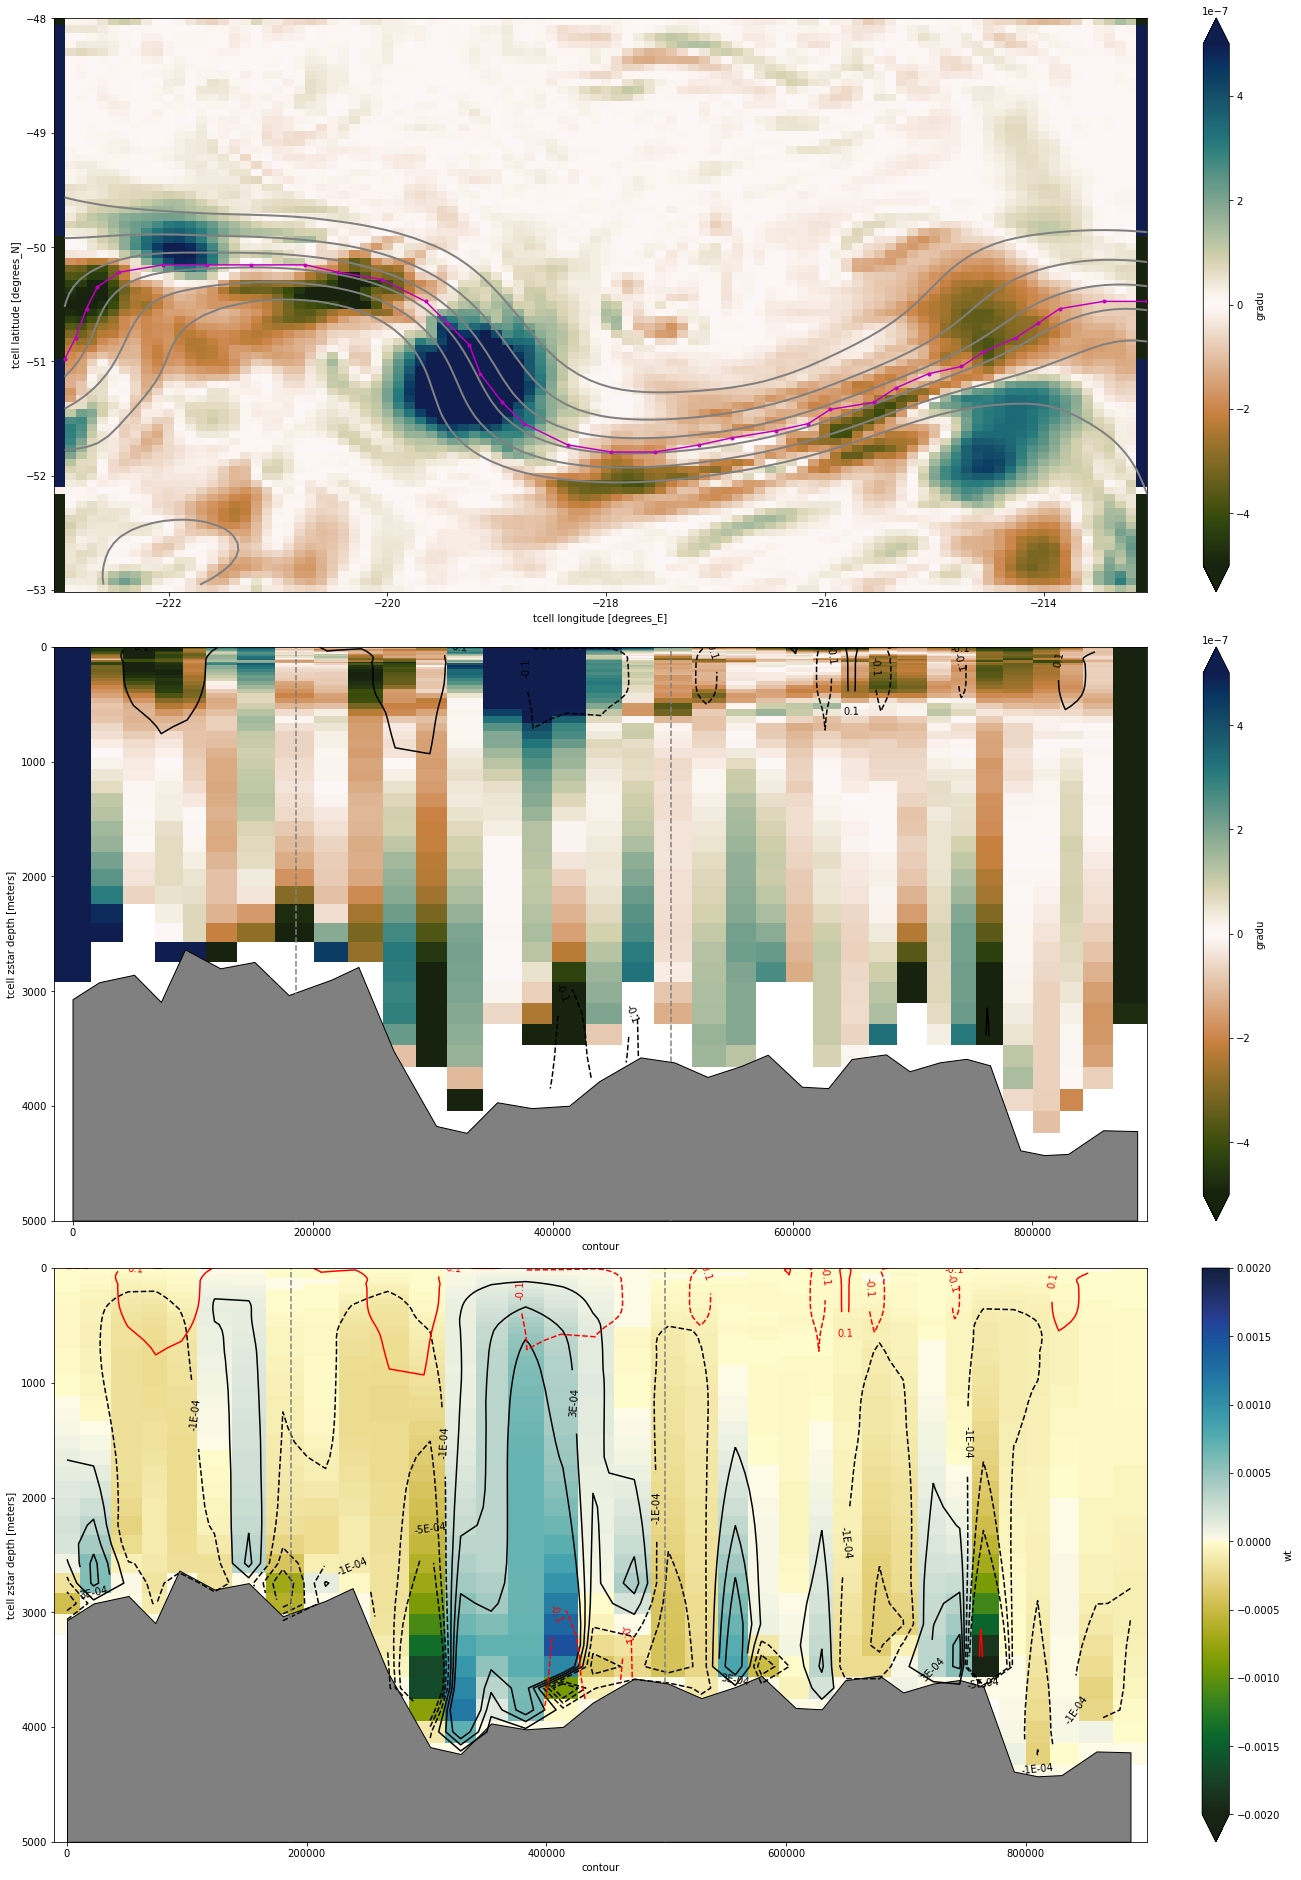

In [29]:
# wt_contours = np.linspace(-1e-3, 1e-3, 6)
# v_levels = np.linspace(-.5, .5, 6)

# nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=3, figsize=(18,26), constrained_layout=True)

# horizontal divergence surface
gradu.sel(st_ocean=200, method='nearest').plot(
    ax=ax[0], cmap=cmo.cm.tarn, vmin=-5e-7, vmax=5e-7)
sea_level.plot.contour(
    ax=ax[0], levels=np.linspace(-0.6, -0.1, 6), linestyles='solid', linewidths=2, colors='gray')

ax[0].plot(sl_cont.xt_ocean, sl_cont.yt_ocean, '.-', color='m')


# horizontal divergence along contour
div_cont.plot(ax=ax[1], x='contour', cmap=cmo.cm.tarn, vmin=gradu_limits[0], vmax=gradu_limits[1])

# cross-contour horizontal velocity
cont = uv_cont.vn.plot.contour(ax=ax[1], x='contour', colors='k', levels=vn_contours[::2])
ax[1].clabel(cont, vn_contours[::2], inline=1, fmt='%.1f')

# vertica velocity
wt_cont.plot(ax=ax[2], x='contour', cmap=cmo.cm.delta_r, vmin=wt_limits[0], vmax=wt_limits[1])
cont = wt_cont.plot.contour(ax=ax[2], x='contour', levels=wt_contours, colors='k')
ax[2].clabel(cont, wt_contours[::2], inline=1, fmt='%.0E')
cont = uv_cont.vn.plot.contour(ax=ax[2], x='contour', colors='r', levels=vn_contours[::2])
ax[2].clabel(cont, vn_contours[::2], inline=1, fmt='%.1f')

for i in range(len(ax)):
    
    # indication of trough and crest
    ax[i].axvline(find_nearest(div_cont, trough, x_coord='xu_ocean'), linestyle='dashed', color='gray')
    ax[i].axvline(find_nearest(div_cont, crest, x_coord='xu_ocean'), linestyle='dashed', color='gray')
    
    if i >= 1:
        # topography
        ax[i].fill_between(ht_cont.contour, ht_cont, 5000, facecolor='gray', ec='k')
        ax[i].set_ylim([0,5000])
        ax[i].invert_yaxis()

In [30]:
print('%s-day mean field (%s)' %(len(div_hu_gcm.sel(time=flex_period).time), len(xr.merge([u_lim, v_lim]).sel(time=flex_period).time)))

16-day mean field (16)


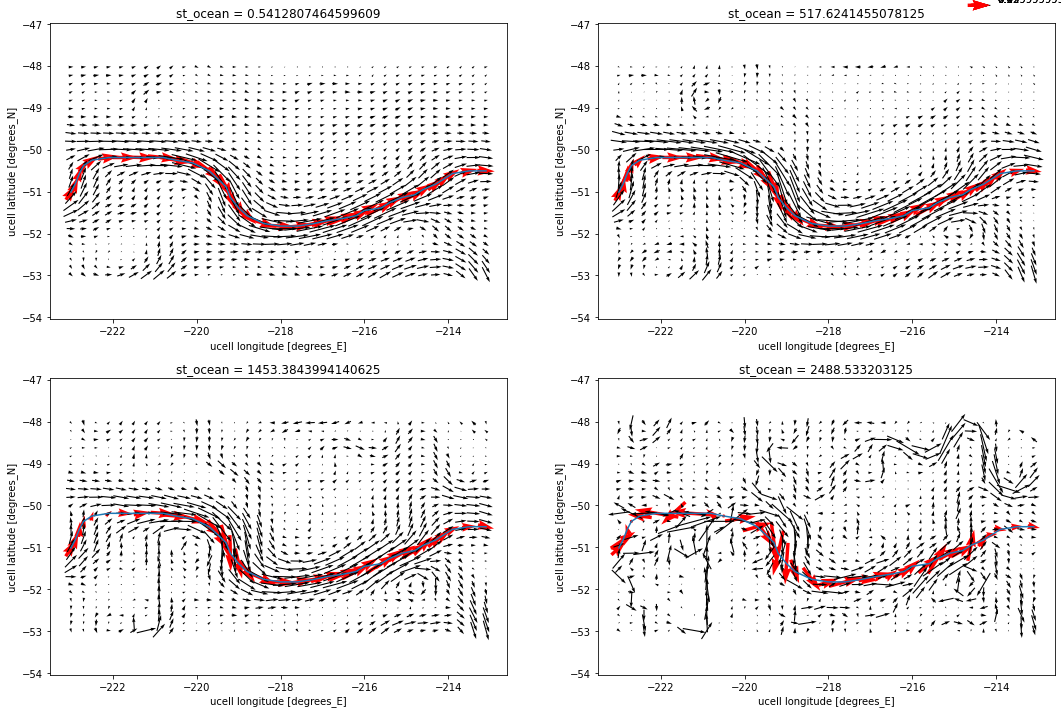

In [33]:
nrows, ncols = 2, 2
slc = slice(None, None, 3)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,12))
depths = [0, 500, 1500, 2500]
for iax, depth in enumerate(depths):
    r, c = iax // ncols, iax % ncols
    
    uv_cont.sel(st_ocean=depth, method='nearest').plot.quiver(
        ax=ax[r,c], x='xu_ocean', y='yu_ocean', u='u', v='v', color='r')
    
    ax[r,c].plot(uv_cont.xu_ocean, uv_cont.yu_ocean)
    
    velocity.sel(st_ocean=depth, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
        ax=ax[r,c], x='xu_ocean', y='yu_ocean', u='u', v='v', label=depth)
    ax[r,c].axis('equal')

In [32]:
cont = uv_cont.vn.plot.contour(ax=ax[1], x='contour', colors='k', levels=vn_contours[::2])


AttributeError: 'numpy.ndarray' object has no attribute 'contour'

In [ ]:
# fig, ax = plt.subplots(figsize=(20,12))

# # # horizontal divergence
# # div_cont.plot(ax=ax, x='contour', cmap=cmo.cm.tarn, vmin=gradu_limits[0], vmax=gradu_limits[1])

# # vertica velocity
# wt_cont.plot(ax=ax, x='contour', cmap=cmo.cm.delta_r, vmin=wt_limits[0], vmax=wt_limits[1])
# cont = wt_cont.plot.contour(ax=ax, x='contour', levels=wt_contours, colors='k')

# # indication of trough and crest
# ax.axvline(find_nearest(div_cont, trough, x_coord='xu_ocean'), linestyle='dashed', color='gray')
# ax.axvline(find_nearest(div_cont, crest, x_coord='xu_ocean'), linestyle='dashed', color='gray')

# # topography
# ax.fill_between(ht_cont.contour, ht_cont, 5000, facecolor='gray', ec='k')
# ax.set_ylim([0,5000])
# ax.invert_yaxis()

In [ ]:
wt_lim.sel(time=flex_period).mean('time').sel(sw_ocean=0, method='nearest').plot(
    cmap=cmo.cm.delta_r)

In [ ]:
flex_period

In [ ]:
wt_ekm_lim.sel(time='1997-04-16').plot(cmap=cmo.cm.delta_r)

In [ ]:
tau_x = cc.querying.getvar(expt=expt, variable='tau_x', session=session, frequency='1 monthly', start_time=start, end_time=end)
tau_y = cc.querying.getvar(expt=expt, variable='tau_y', session=session, frequency='1 monthly', start_time=start, end_time=end)


In [ ]:
tau_x_lim = tau_x.sel(xu_ocean=lon_lim, yu_ocean=lat_lim).sel(time='1997-04-16')
tau_y_lim = tau_y.sel(xu_ocean=lon_lim, yu_ocean=lat_lim).sel(time='1997-04-16')



In [ ]:
from gsw import f

In [ ]:
wind_stress = xr.merge([tau_x_lim, tau_y_lim])


fcor = np.broadcast_to(f(wind_stress.yu_ocean).values[np.newaxis].T, wind_stress.tau_x.shape[1:])
rho=1025


tau = np.sqrt(wind_stress.tau_x**2 + wind_stress.tau_y**2)
tau.name = 'tau'

uE = wind_stress.tau_y/(fcor*rho)
vE = -wind_stress.tau_x/(fcor*rho)
uE.name, vE.name = 'uE', 'vE'

wind_stress = xr.merge([wind_stress, tau, uE, vE])


In [ ]:
wind_stress

In [ ]:
help(ds.plot.quiver)

In [ ]:
slc = xt_ocean=slice(None, None, 4)

# wind_stress.tau.plot(size=8)
# wind_stress.isel(time=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
#     x='xu_ocean', y='yu_ocean', u='uE', v='vE')
wind_stress.isel(time=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(size=10,
    x='xu_ocean', y='yu_ocean', u='tau_x', v='tau_y', color='r', scale=10)


In [ ]:
ue.values.max()

In [ ]:
wind_stress.vE.values.max()